# Sun Race 2179 - Part 01

![Giant prominence on the sun erupted - NASA](images/Giant_prominence_on_the_sun_erupted.jpg)

A new story starts as a rush, filled with a deluge of sensations and experiences, and - in moments - I understand the broad outline of the events. Perhaps not any of the characters who will populate it, but certainly the broad range of the narrative.

Then, slowly, I experience fragmentary vignettes. Tiny optical dioramas stripped of context or time, featuring characters, sensations.

As these facets of the story take shape, I begin my search for doorwarys into the narrative. A way to start; to see what these pieces will become. And, usually, I find these doorways through music.

[Dardust - Sunset on M.](https://www.youtube.com/watch?v=wlkDFQxIbw4)

*As I listened, I could see a solar-sail space ship, passing close to the sun. The crew of the yacht are standing quietly. Scarcely moving. Waiting...*

And, finally, once the shape and entry are known, I begin my research to understand the world in which the narrative will take place. To place my story in context, to anchor it to a real place and time.

## A novel of a yachting disaster that happened in 2179

I am a *future realism* [writer](https://gavinchait.com) and my next novel is about a yachting disaster that took place during the biannual Sun Race of 2179, almost exactly 200 years after the [Fastnet tragedy of 1979](https://www.amazon.co.uk/Fastnet-Force-10-Deadliest-History-ebook/dp/B007HXKY86/).

The objective of the solar yacht race is to sail a purely mechanical space-yacht from Mercury around the Sun and then return to Mercury.

I do a great deal of research during each of my novels, most of which never makes it into the narrative except in very subtle ways. For example, I spent two weeks researching and calculating the mass and energy potential for [aluminium air batteries](https://en.wikipedia.org/wiki/Aluminium%E2%80%93air_battery) in my first novel, [Lament for the Fallen](https://lamentforthefallen.com).

I've decided to do things differently this time and show the sausage-making process.

In this series I will be working through the fundamental physics of the race with the objective of showing what would be required (very superficially) for such an event to take place, and the sorts of challenges that each ship's navigators will have to overcome.

In this first section I'm not overly worried about things like whether the craft itself will survive getting so close to the Sun, or how to move the yacht using solar sails, or even what the crew would be doing. I'm focused on the core mechanics of bodies in motion subject to [Newton's Law of Gravitation](https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation).

## Developing an understanding of the core orbital mechanics for a solar yacht race

The Solar Yacht Race sees mechanical solar sail craft competing in a race between Mercury and the Sun. 

The largest initial motivational force is that of gravity amongst all the different bodies concerned. In mathematical terms this is an *n-body* problem where the gravitational forces of the various bodies involved act upon each other ([Ref: Numerical Integration of the n-Body Problem, Harrison Brown](http://ccar.colorado.edu/asen5050/projects/projects_2013/Brown_Harrison/Code/Brown_H.pdf)).

According to Newton's Law of Gravitation, the force ($\overrightarrow{f_i}$) between different masses ($m$) at various vector positions ($\overrightarrow{r_i}$), and subject to the universal gravitation constant ($G$), can be calculated as:

$$\overrightarrow{f_i} = G\sum_{k=1, k \neq i}^n\frac{m_i m_j}{r_{ij}^3}(\overrightarrow{r_j}-\overrightarrow{r_i})$$

If you think of Mercury in space some 57 million kilometres away from the cente of the Sun, then the two objects 'fall' towards each other under the force of gravity. Since each is moving, they end up rotating around their collective centre of mass.

Since the Sun is quite extraordinarily heavy (1.99x10^30 kgs), and the mass of Mercury is only about 0.000016% of that, the impact of the other planets on Mercury is quite small. The yachts, similarly, are more influenced by the Sun than they are by Mercury ... although Mercury's effect is still present.

The degree of the gravitational forces involved change depending on the relationship between the vector positions of each mass (i.e. how far they are apart, and how that relative position changes in motion). Bodies in motion experience different degrees of attraction, and these forces dictate orbital path.

To assess the yacht race route, we need to solve for these forces.

This is relatively easy to solve using an Ordinary Differential Equation (ODE). Presenting Newton's law of gravity for *n* bodies as an ODE:

$$\ddot{\overrightarrow{r_i}} = G\sum_{k=1, k \neq i}^n\frac{m_j}{r_{ij}^3}(\overrightarrow{r_j}-\overrightarrow{r_i})$$

Where $\ddot{\vec{r_i}}$ is the ordinary differential accelleration vector (i.e. the rate of change of velocity, which itself is the rate of change of position).

Which looks horrible for anyone who doesn't work with it daily. Fortunately, [Rebound](https://github.com/hannorein/rebound) (and [ReboundX](https://github.com/dtamayo/reboundx)) are Python libraries that permit calculation of arbitrary astronomical bodies (particles) in motion, leading to code that is relatively simple and readable:

Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).


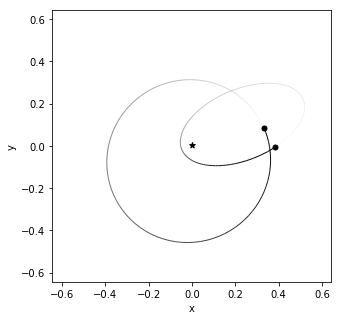

In [1]:
# Import the libaries we need
import rebound
import math
import numpy as np
import matplotlib.pyplot as plt
# Create the simulation
sim = rebound.Simulation()
# Add the sun at the centre of the simulated system
sim.add('Sun')
# Add our craft, positioned at the same position and orbital velocity as Mercury
# This position isn't important just yet, we simply want to get our code working
sim.add(m=1200./1.99e30, x=0.3871, vx=1.15, vy=0.77)
# Add Mercury
sim.add('Mercury')
# Draw the simulation
%matplotlib inline
fig = rebound.OrbitPlot(sim)

Now, maybe you're thinking, why do we need to factor Mercury into the simulation given that its effect on the yachts is quite small?

For multiple reasons, the most important of which is that this is a yacht race, and Mercury is both the starting and the end-point. And Mercury moves ...

Lets run the simulation again, this time integrating step-by-step at specific times, and you can see how the various objects end up at different positions.

Note, we're working in three-dimensional vector space (x, y, z) but vectors can be converted into a radius of distance for convenience ($r = \sqrt{x^2 + y^2 + z^2}$). This is the relative distance between the centre of the sun and that of the solar yacht.

Before I go much further, it's useful to recognise that the distances, masses and velocities involved are enormous. So to bring these down to relative terms, the convention is to present the units as proportions of either the Earth or Sun. For example, the distance from the Sun to the Earth is one astronomical unit (1AU) instead of 1.49x10^6km, and velocity is a proportion of the Earth's velocity around the Sun. Mass can be presented as a proportion of the Sun's mass.

You'll see me 'correct' for these units to bring the results into something an Earth-based observer would understand.

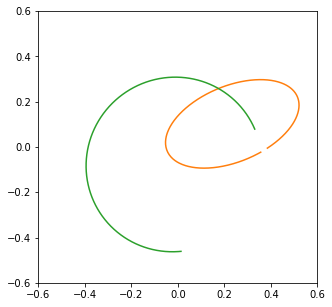

In [2]:
# We'll do our calculation over our race period, getting both the positional arguments (x,y,z)
# and the velocities (vx, vy, vz) to plot on our chart.
# Start the simulation and plot the results
Noutputs = 1000 # The number of sampled positions in the simulation we want to plot
year = 2.*np.pi # One year in units where G=1
racetime = (60/365)*year # This is the time we'll plot, calculated in Earth days, approximately
Earthvelocity =  29796 # Velocity is expressed as a proportion of Earth's in m/s
times = np.linspace(0.,racetime, Noutputs) # Creating a list of times from 0 to racetime divided by Noutputs
# First we create a set of arrays to store the vector positions and velocities
x = np.zeros((3,Noutputs)) # Only the sun and the yacht, so a matrix consisting of 2 rows
y = np.zeros((3,Noutputs))
z = np.zeros((3,Noutputs))
vx = np.zeros((1,Noutputs)) # And the velocities
vy = np.zeros((1,Noutputs))
vz = np.zeros((1,Noutputs))
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs
# Remember, Sun is at 0 and Yacht is at 1
for i,time in enumerate(times):
    sim.integrate(time) # Storing the vector positions
    x[0][i] = ps[0].x  # Sun
    y[0][i] = ps[0].y
    z[0][i] = ps[0].z
    x[1][i] = ps[1].x  # Yacht
    y[1][i] = ps[1].y
    z[1][i] = ps[1].z
    x[2][i] = ps[2].x  # Mercury
    y[2][i] = ps[2].y
    z[2][i] = ps[2].z
    vx[0][i] = ps[1].vx # And the vector velocity for the yacht
    vy[0][i] = ps[1].vy
    vz[0][i] = ps[1].vz
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-0.6,0.6])
ax.set_ylim([-0.6,0.6])
plt.plot(x[0], y[0])
plt.plot(x[1], y[1])
plt.plot(x[2], y[2])

You can see that the yacht does a complete orbit and Mercury is still only part-way round. For the yacht race to end at Mercury requires some steering, which is where the sailing part of the race comes in. For the moment, it's useful to understand what is happening in an unmediated situation between these orbiting particles.

Looking further, you can see how the yacht's position and velocity changes w.r.t. the Sun:

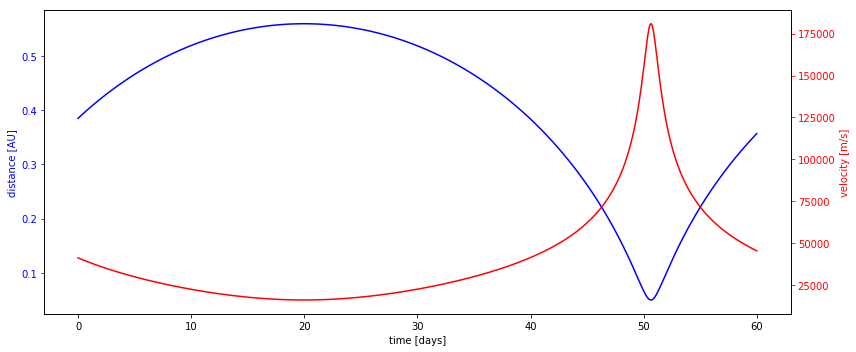

In [3]:
distance = np.sqrt(np.square(x[0]-x[1])+np.square(y[0]-y[1])+np.square(z[0]-z[1]))
velocity = np.sqrt(np.square(vx[0])+np.square(vy[0])+np.square(vz[0]))*Earthvelocity
yearfix = 365./(2.*np.pi) # Convert radians to days
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(times*yearfix, distance, 'b-')
ax1.set_xlabel("time [days]")
ax1.set_ylabel("distance [AU]", color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.set_ylabel("velocity [m/s]", color='r')
ax2.tick_params('y', colors='r')
ax2.plot(times*yearfix, velocity, 'r-')
fig.tight_layout()
plt.show()

As you can see, as the yacht gets closer to the sun its velocity increases dramatically.

In [4]:
closeencountertime = times[np.argmin(distance)]*yearfix
print("Minimum distance (%f AU) occured at time: %2.2f days." % (np.min(distance),closeencountertime))
greatestvelocity = times[np.argmax(velocity)]*yearfix
print("Maximum velocity (%6.2f m/s) occured at time: %2.2f days." % (np.max(velocity),greatestvelocity))

Minimum distance (0.049795 AU) occured at time: 50.63 days.
Maximum velocity (180950.41 m/s) occured at time: 50.63 days.


However, 0.05AU is 7.4 million km from the Sun; still too far away for what I have in mind for the story.

In the next chapter, I need to achieve the following things:

- Decide on a starting position for the yachts;
- Navigate the yachts from their starting position to finish at Mercury;
- Ensure that the yachts get to within 1 million km of the Sun while doing so;